In [3]:
pwd

'C:\\Users\\admin\\Downloads'

In [91]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils
from pytorch_lightning.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.manifold import TSNE
from itertools import combinations

In [23]:
num_workers = 8
batch_size = 32
seed = 1
max_epochs = 50
input_size = 256
num_ftrs = 32

In [24]:
path_to_data = "images"

In [25]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)


dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True
)

In [26]:
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [27]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="simclr_model",
    save_top_k=1,
    verbose=True,
    monitor="train_loss_ssl",
    mode="min"
)

In [28]:
trainer = pl.Trainer(
    max_epochs=max_epochs,
    devices=1,
    accelerator="auto",
    callbacks=[checkpoint_callback]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
model = SimCLRModel()

In [30]:
trainer.fit(model, dataloader_train_simclr)

# Save the final model checkpoint
trainer.save_checkpoint("simclr_model.ckpt")


  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M | train
1 | projection_head | SimCLRProjectionHead | 328 K  | train
2 | criterion       | NTXentLoss           | 0      | train
-----------------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 125: 'train_loss_ssl' reached 4.21284 (best 4.21284), saving model to 'C:\\Users\\admin\\Downloads\\checkpoints\\simclr_model.ckpt' as top 1
Epoch 1, global step 250: 'train_loss_ssl' was not in top 1
Epoch 2, global step 375: 'train_loss_ssl' reached 4.03747 (best 4.03747), saving model to 'C:\\Users\\admin\\Downloads\\checkpoints\\simclr_model.ckpt' as top 1
Epoch 3, global step 500: 'train_loss_ssl' was not in top 1
Epoch 4, global step 625: 'train_loss_ssl' reached 3.92569 (best 3.92569), saving model to 'C:\\Users\\admin\\Downloads\\checkpoints\\simclr_model.ckpt' as top 1
Epoch 5, global step 750: 'train_loss_ssl' was not in top 1
Epoch 6, global step 875: 'train_loss_ssl' was not in top 1
Epoch 7, global step 1000: 'train_loss_ssl' reached 3.63306 (best 3.63306), saving model to 'C:\\Users\\admin\\Downloads\\checkpoints\\simclr_model.ckpt' as top 1
Epoch 8, global step 1125: 'train_loss_ssl' was not in top 1
Epoch 9, global step 1250: 'train_loss_ssl' was no

                                                              Sclerotic embeddings

In [31]:
num_workers = 8
batch_size = 32
seed = 1
max_epochs = 50
input_size = 256
num_ftrs = 32

In [32]:
path_to_data = "public\public\globally_sclerotic_glomeruli"
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)


In [33]:
dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [34]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


In [35]:
model = SimCLRModel.load_from_checkpoint("checkpoints/simclr_model.ckpt")
model.eval()

# Generate embeddings using the trained simclr model
embeddings_dict = generate_embeddings(model, dataloader_test)

In [36]:
embeddings, filenames = embeddings_dict

print("Embedding shape:", embeddings.shape)  

for filename in filenames:
    print(filename)
    break;


Embedding shape: (317, 512)
18-162_PAS_1of6_64551bed435c92704a3a2159.png


In [39]:
groundtruth = 'public/public/public.csv'
df = pd.read_csv(groundtruth )

sclerotic_truth_values = []

for filename in filenames:
    ground_truth_row = df[df['name'] == filename]
    if not ground_truth_row.empty:
        ground_truth_value = ground_truth_row['ground truth'].values[0] 
        sclerotic_truth_values.append(ground_truth_value)

sclerotic_truth_array = np.array(sclerotic_truth_values)

In [40]:
sclerotic_truth_array

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [41]:
np.save('simclr/sclerotic_embeddings',embeddings)

In [42]:
x_sclerotic = np.load('simclr/sclerotic_embeddings.npy')

In [43]:
y_sclerotic = sclerotic_truth_array

In [44]:
y_sclerotic 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [45]:
pwd

'C:\\Users\\admin\\Downloads'

                                                                    Non- Sclerotic embeddings

In [46]:
path_to_data = "public\public\9on_globally_sclerotic_glomeruli"  #rename folder name as 9on because \n is considered space and shows no directory if \non
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [47]:
dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [48]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


In [49]:
model = SimCLRModel.load_from_checkpoint("checkpoints/simclr_model.ckpt")
model.eval()

# Generate embeddings using the trained simclr model
embeddings_dict = generate_embeddings(model, dataloader_test)

In [50]:
embeddings, filenames = embeddings_dict

print("Embedding shape:", embeddings.shape)  

for filename in filenames:
    print(filename)
    break;


Embedding shape: (1412, 512)
18-142_PAS_1of6_647e17ac435c92704a564fdd.png


In [51]:
groundtruth = 'public/public/public.csv'
df = pd.read_csv(groundtruth )

non_sclerotic_truth_values = []

for filename in filenames:
    ground_truth_row = df[df['name'] == filename]
    if not ground_truth_row.empty:
        ground_truth_value = ground_truth_row['ground truth'].values[0] 
        non_sclerotic_truth_values.append(ground_truth_value)

non_sclerotic_truth_array = np.array(non_sclerotic_truth_values)

In [52]:
non_sclerotic_truth_array

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [53]:
np.save('simclr/non_sclerotic_embeddings',embeddings)

In [54]:
x_non_sclerotic = np.load('simclr/non_sclerotic_embeddings.npy')

In [55]:
y_non_sclerotic = non_sclerotic_truth_array

In [56]:
y_non_sclerotic

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

                                                        merging embeddings

In [57]:
x = np.concatenate((x_non_sclerotic,x_sclerotic),axis=0)

In [58]:
x

array([[0.06662908, 0.04686869, 0.06183401, ..., 0.03158099, 0.04397485,
        0.02083434],
       [0.03470571, 0.05160965, 0.06382655, ..., 0.01492702, 0.04523422,
        0.00228269],
       [0.06150391, 0.05232879, 0.04968811, ..., 0.05538179, 0.02271805,
        0.02574159],
       ...,
       [0.00496654, 0.05552277, 0.04941828, ..., 0.04893304, 0.00355234,
        0.04017493],
       [0.00668712, 0.0358775 , 0.02698998, ..., 0.02413049, 0.        ,
        0.04985427],
       [0.0055932 , 0.04185857, 0.03090556, ..., 0.0236011 , 0.00017053,
        0.05104602]])

In [59]:
y = np.concatenate((y_non_sclerotic,y_sclerotic),axis=0)

In [60]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

                                                        PCA

In [61]:
pca = PCA(n_components=150)  
x_sclerotic_pca = pca.fit_transform(x_sclerotic)
x_sclerotic_pca.shape

(317, 150)

In [62]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([4.19190699e-01, 1.68482743e-01, 1.23681640e-01, 1.00167311e-01,
       4.92200721e-02, 3.11053831e-02, 1.82636522e-02, 1.33987795e-02,
       1.10137540e-02, 8.65779062e-03, 6.15666903e-03, 5.90708057e-03,
       4.37429504e-03, 3.85223586e-03, 3.40344560e-03, 2.96274661e-03,
       2.35474870e-03, 1.94180926e-03, 1.71446102e-03, 1.44137738e-03,
       1.25089480e-03, 1.12602890e-03, 1.02824199e-03, 1.00550928e-03,
       7.88659933e-04, 7.77578558e-04, 7.28837478e-04, 7.01638462e-04,
       6.25060976e-04, 5.87735851e-04, 5.82187117e-04, 5.13697387e-04,
       4.73505592e-04, 4.34276230e-04, 4.08719317e-04, 3.93003409e-04,
       3.53521583e-04, 3.40449044e-04, 3.27216055e-04, 3.16023638e-04,
       2.91339750e-04, 2.64740955e-04, 2.51759274e-04, 2.45461466e-04,
       2.34086429e-04, 2.27376870e-04, 2.16415080e-04, 2.06928891e-04,
       1.98479168e-04, 1.93879174e-04, 1.83213713e-04, 1.69248954e-04,
       1.60772149e-04, 1.51015981e-04, 1.46891965e-04, 1.44876208e-04,
      

In [63]:
sum(explained_variance_ratio)

0.9986841479224007

In [64]:
pca = PCA(n_components=150)  
x_non_sclerotic_pca = pca.fit_transform(x_non_sclerotic)
x_non_sclerotic_pca.shape

(1412, 150)

In [65]:
explained_variance_ratio = pca.explained_variance_ratio_

In [66]:
sum(explained_variance_ratio)

0.9975686822899207

                                                         combined_pca

In [67]:
x_combined_pca = np.vstack((x_non_sclerotic, x_sclerotic))

class_labels = np.hstack((['Non-Sclerotic'] * x_non_sclerotic.shape[0], 
                          ['Sclerotic'] * x_sclerotic.shape[0]))

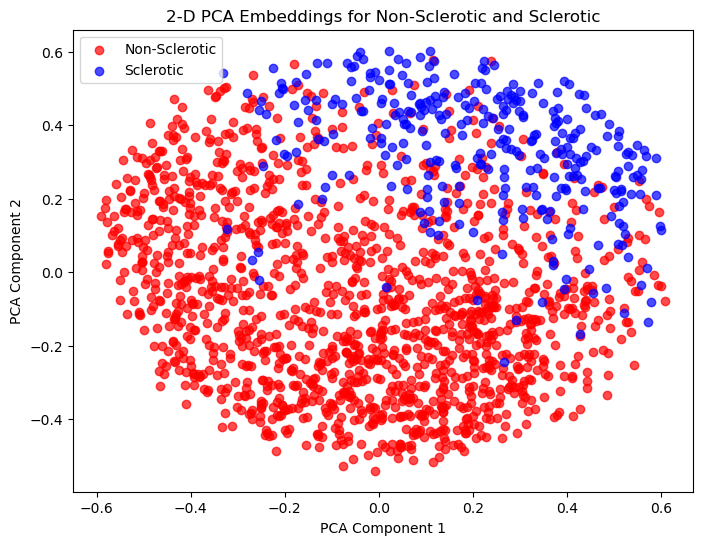

In [68]:
pca_2d = PCA(n_components=2)
x_combined_2d = pca_2d.fit_transform(x_combined_pca)

plt.figure(figsize=(8, 6))
plt.scatter(x_combined_2d[class_labels == 'Non-Sclerotic', 0], x_combined_2d[class_labels == 'Non-Sclerotic', 1], 
            label='Non-Sclerotic', alpha=0.7, color='r')
plt.scatter(x_combined_2d[class_labels == 'Sclerotic', 0], x_combined_2d[class_labels == 'Sclerotic', 1], 
            label='Sclerotic', alpha=0.7, color='b')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('2-D PCA Embeddings for Non-Sclerotic and Sclerotic')
plt.savefig('pca_2d_embeddings.png', format='png')
plt.show()

In [69]:
sum(pca_2d.explained_variance_ratio_)

0.523074566268258

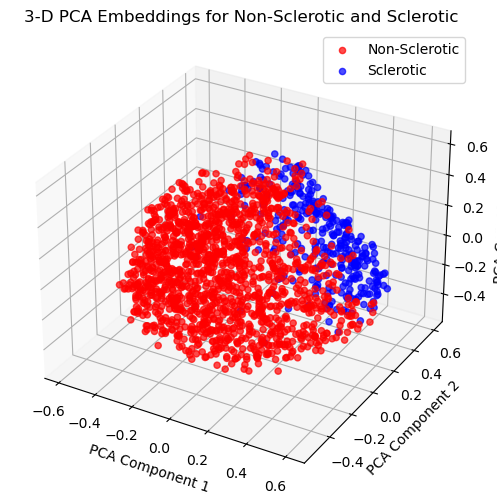

In [70]:
pca_3d = PCA(n_components=3)
x_combined_3d = pca_3d.fit_transform(x_combined_pca)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x_combined_3d[class_labels == 'Non-Sclerotic', 0], x_combined_3d[class_labels == 'Non-Sclerotic', 1], 
           x_combined_3d[class_labels == 'Non-Sclerotic', 2], c='r', label='Non-Sclerotic', alpha=0.7)
ax.scatter(x_combined_3d[class_labels == 'Sclerotic', 0], x_combined_3d[class_labels == 'Sclerotic', 1], 
           x_combined_3d[class_labels == 'Sclerotic', 2], c='b', label='Sclerotic', alpha=0.7)


ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()

plt.title('3-D PCA Embeddings for Non-Sclerotic and Sclerotic')
plt.savefig('pca_3d_embeddings.png', format='png')
plt.show()


In [71]:
sum(pca_3d.explained_variance_ratio_)

0.7109674961854275

In [88]:
x_combined_pca = np.vstack((x_non_sclerotic, x_sclerotic))

pca_full = PCA()
pca_full.fit(x_combined_pca)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

num_components_95

12

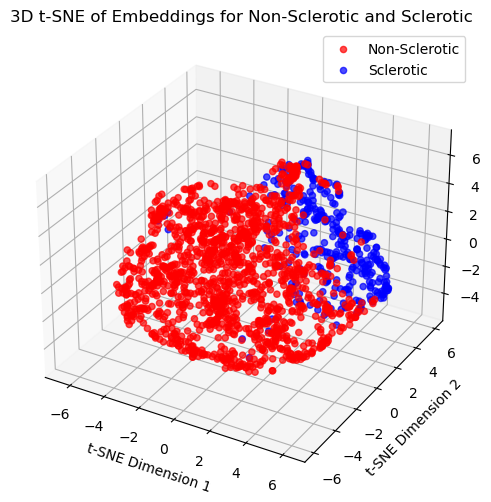

In [72]:
X_combined = np.vstack((x_non_sclerotic, x_sclerotic))

class_labels = np.hstack((['Non-Sclerotic'] * x_non_sclerotic.shape[0], 
                          ['Sclerotic'] * x_sclerotic.shape[0]))

tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
X_tsne_3d = tsne.fit_transform(X_combined)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne_3d[class_labels == 'Non-Sclerotic', 0], 
           X_tsne_3d[class_labels == 'Non-Sclerotic', 1], 
           X_tsne_3d[class_labels == 'Non-Sclerotic', 2], 
           c='r', label='Non-Sclerotic', alpha=0.7)

ax.scatter(X_tsne_3d[class_labels == 'Sclerotic', 0], 
           X_tsne_3d[class_labels == 'Sclerotic', 1], 
           X_tsne_3d[class_labels == 'Sclerotic', 2], 
           c='b', label='Sclerotic', alpha=0.7)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.legend()

plt.title('3D t-SNE of Embeddings for Non-Sclerotic and Sclerotic')
plt.savefig('t-sne_3d_embeddings.png', format='png')
plt.show()

                                                   Supervised Machine learning model training on embeddings generated from Simclr

In [73]:
x_combined = np.vstack((x_non_sclerotic, x_sclerotic))
y_combined = np.hstack((np.zeros(x_non_sclerotic.shape[0]), np.ones(x_sclerotic.shape[0])))
pca_150d = PCA(n_components=150)
x_combined_pca = pca_150d.fit_transform(x_combined)

In [74]:
sum(pca_150d.explained_variance_ratio_)

0.9975930247343214

In [75]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_split.split(x_combined_pca, y_combined):
    X_train, X_test = x_combined_pca[train_index], x_combined_pca[test_index]
    y_train, y_test = y_combined[train_index], y_combined[test_index]

print("Class distribution in training set:", np.bincount(y_train.astype(int)))
print("Class distribution in testing set:", np.bincount(y_test.astype(int)))

Class distribution in training set: [1129  254]
Class distribution in testing set: [283  63]


In [76]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
svm = SVC(class_weight='balanced', random_state=42)

logreg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
svm.fit(X_train, y_train)

logreg_pred = logreg.predict(X_test)
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))

random_forest_pred = random_forest.predict(X_test)
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, random_forest_pred))
print(classification_report(y_test, random_forest_pred))

svm_pred = svm.predict(X_test)
print("\nSVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

Logistic Regression Results:
Accuracy: 0.8988439306358381
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93       283
         1.0       0.65      0.95      0.77        63

    accuracy                           0.90       346
   macro avg       0.82      0.92      0.85       346
weighted avg       0.93      0.90      0.91       346


Random Forest Results:
Accuracy: 0.9075144508670521
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95       283
         1.0       0.88      0.57      0.69        63

    accuracy                           0.91       346
   macro avg       0.89      0.78      0.82       346
weighted avg       0.91      0.91      0.90       346


SVM Results:
Accuracy: 0.8959537572254336
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       283
         1.0       0.66      0.90      0.76        63

    accuracy                

In [94]:
X_train.shape

(1383, 150)

In [96]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [98]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(150,)),         
    tf.keras.layers.Dense(128, activation='relu'),           
    tf.keras.layers.Dropout(0.3),                           
    tf.keras.layers.Dense(64, activation='relu'),           
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')           
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=50, batch_size=1)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


y_pred = np.argmax(model.predict(X_test), axis=-1)


print(classification_report(y_test, y_pred))

Epoch 1/50
1383/1383 [==============================] - 3s 2ms/step - loss: 0.2074 - accuracy: 0.9140
Epoch 2/50
1383/1383 [==============================] - 2s 2ms/step - loss: 0.1368 - accuracy: 0.9479
Epoch 3/50
1383/1383 [==============================] - 3s 2ms/step - loss: 0.1143 - accuracy: 0.9544
Epoch 4/50
1383/1383 [==============================] - 3s 2ms/step - loss: 0.1084 - accuracy: 0.9566
Epoch 5/50
1383/1383 [==============================] - 2s 2ms/step - loss: 0.0798 - accuracy: 0.9696
Epoch 6/50
1383/1383 [==============================] - 2s 2ms/step - loss: 0.0880 - accuracy: 0.9631
Epoch 7/50
1383/1383 [==============================] - 2s 2ms/step - loss: 0.0750 - accuracy: 0.9783
Epoch 8/50
1383/1383 [==============================] - 3s 2ms/step - loss: 0.0607 - accuracy: 0.9798
Epoch 9/50
1383/1383 [==============================] - 3s 2ms/step - loss: 0.0616 - accuracy: 0.9747
Epoch 10/50
1383/1383 [==============================] - 3s 2ms/step - loss: 0.057

In [99]:
model.save('simclr_neuralnetwork_model.h5') 